# Part 1 | Augmented Reality

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir drive/MyDrive/ar

mkdir: cannot create directory ‘drive/MyDrive/ar’: File exists


In [ ]:
! mkdir drive/MyDrive/ar/out
! mkdir drive/MyDrive/ar/assets

mkdir: cannot create directory ‘drive/MyDrive/ar/out’: File exists
mkdir: cannot create directory ‘drive/MyDrive/ar/assets’: File exists


## Importing Libraries

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os


## Constants

In [ ]:
OUT = 'drive/MyDrive/ar/out'
if not os.path.exists(OUT):
    os.makedirs(OUT)
    
IN = 'drive/MyDrive/ar/assets/Part 1'

## Reading the cover image

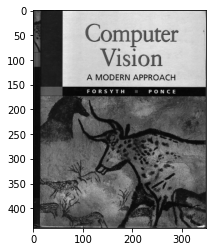

In [ ]:
cover = cv2.imread(IN + '/cv_cover.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(cover, cmap='gray')

## Reading the videos

In [ ]:
def loadVid(path):
	# Create a VideoCapture object and read from input file
	# If the input is the camera, pass 0 instead of the video file name
	cap = cv2.VideoCapture(path)
	 
	# Check if camera opened successfully
	if (cap.isOpened()== False): 
		print("Error opening video stream or file")

	i = 0
	# Read until video is completed
	while(cap.isOpened()):
		# Capture frame-by-frame
		i += 1
		ret, frame = cap.read()
		if ret == True:

			#Store the resulting frame
			if i == 1:
				frames = frame[np.newaxis, ...]
			else:
				frame = frame[np.newaxis, ...]
				frames = np.vstack([frames, frame])
				frames = np.squeeze(frames)
			
		else: 
			break
	 
	# When everything done, release the video capture object
	cap.release()

	return frames


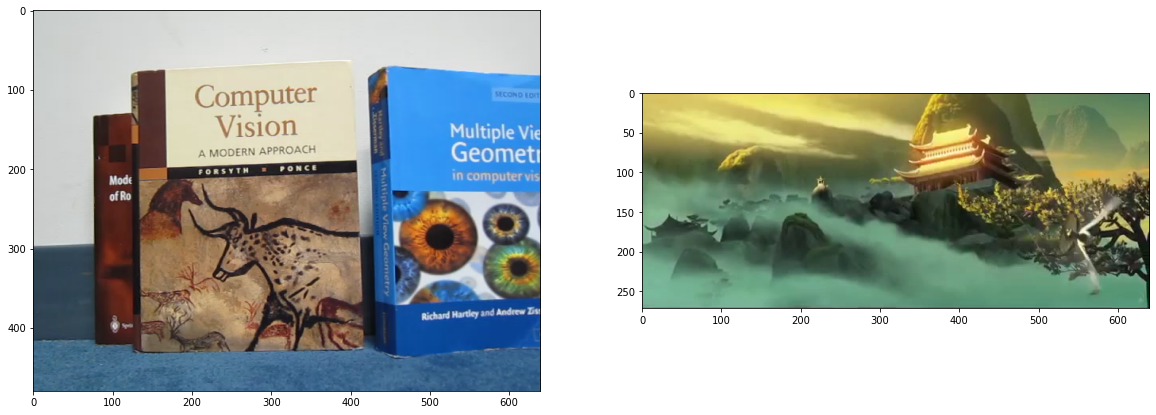

In [ ]:
# book_frames = loadVid(f'{IN}/book.mov')
# trailer_frames = loadVid(IN + '/ar_source.mov')

# save the captured videos to save time

# np.save(OUT + '/book_frames.npy', book_frames)
# np.save(OUT + '/trailer_frames.npy', trailer_frames)

# load the saved videos

book_frames = np.load(OUT + '/book_frames.npy')

# load trailer and remove black broders
trailer_frames = np.load(OUT + '/trailer_frames.npy')[:,44:-44,:]

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(book_frames[0,:,:,::-1])
axes[1].imshow(trailer_frames[0,:,:,::-1])	

## Get dimensions

In [ ]:
# book video dimensions
book_h, book_w = book_frames[0].shape[:2]

# trailer video dimensions
trailer_h, trailer_w = trailer_frames[0].shape[:2]

# Cover image dimensions
cover_h, cover_w = cover.shape[:2]

## Calculating the homography matrix

### commom.py


In [ ]:
import math

# RANSAC parameters
SAMPLE_SIZE = 8 #number of point correspondances for estimation of Homgraphy
SUCCESS_PROB = 0.995 #required probabilty of finding H with all samples being inliners

# 1.1 Getting Correspondences
# Feature of the two image using SIFT
def get_image_sift_feature(img):
    # Check if the image need to be converted to gray
    gray_img = img
    if img.ndim != 2:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # create SIFT object
    sift = cv2.SIFT_create()
    # detect SIFT features in both images
    keypoints, descriptors = sift.detectAndCompute(gray_img, None)

    return keypoints, descriptors


# Get the matched feature between the two image
def get_matches(des1, des2, ratio=0.75):
    # Brute force matcher
    bf = cv2.BFMatcher()
    # match descriptors of both images
    matches = bf.knnMatch(des1, des2, k=2)
    matches_list = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            matches_list.append([m])

    return sorted(matches_list,key=lambda x:x[0].distance) # sort results from the best keypoints to worst

# 1.2 Compute the Homography Parameters
# The point that match the 2 image
def get_matched_pt(kpt, matched_list, points_type = 0, num_pts=50):
    # TODO: check if the function returning the desirable array shape
    """Function to extract the (x, y) points from brute-force knn matcher points
    Args:
        kpt (cv2.KeyPoint array): of shape (n, 1)
        matched_list (2D cv2.DMatch array): of shape (n, 1, 1) represting n set of x, y points
        points_type (number): pass 0 for query points, and 1 for train points
    """
    pts = np.float32([kpt[m[0].queryIdx if points_type == 0 else m[0].trainIdx].pt for m in matched_list[:num_pts]])

    return pts

# Get the homograph matrix using the SVD
def get_homograph_mat(pts_dst, pts_src):
    a_mat = np.zeros((pts_src.shape[0] * 2, 9))

    # Build the A matrix Ah=0
    for i in range(len(pts_src)):
        x = pts_src[i][0]
        y = pts_src[i][1]
        x_dash = pts_dst[i][0]
        y_dash = pts_dst[i][1]
        a_mat[i * 2] += [-x , -y, -1, 0, 0, 0, x * x_dash, y * x_dash, x_dash]
        a_mat[i * 2 + 1] += [0, 0, 0, -x, -y, -1, x * y_dash, y * y_dash, y_dash]

    U, D, V = np.linalg.svd(a_mat, full_matrices=False)
    # Smallest singular value
    homography_mat = (V[-1] / V[-1][-1]).reshape((3, 3))

    return homography_mat


def transform_with_homography(h_mat, points_array):
    # add column of ones so that matrix multiplication with homography matrix is possible
    ones_col = np.ones((points_array.shape[0], 1))
    points_array = np.concatenate((points_array, ones_col), axis=1)
    transformed_points = np.matmul(h_mat, points_array.T)
    epsilon = 1e-7 # very small value to use it during normalization to avoid division by zero
    transformed_points = transformed_points / (transformed_points[2,:].reshape(1,-1) + epsilon)
    transformed_points = transformed_points[0:2,:].T

    return transformed_points

def compute_outliers(h_mat, points_img_a, points_img_b, threshold):
    outliers_count = 0

    # transform the match point in image B to image A using the homography
    points_img_b_hat = transform_with_homography(h_mat, points_img_b)
    # let x, y be coordinate representation of points in image A
    # let x_hat, y_hat be the coordinate representation of transformed points of image B with respect to image A
    x = points_img_a[:, 0]
    y = points_img_a[:, 1]
    x_hat = points_img_b_hat[:, 0]
    y_hat = points_img_b_hat[:, 1]
    euclid_dis = np.sqrt(np.power((x_hat - x), 2) + np.power((y_hat - y), 2)).reshape(-1)
    for dis in euclid_dis:
        if dis > threshold:
            outliers_count += 1

    return outliers_count


def compute_homography_ransac(pts_dst, pts_src, CONFIDENCE_THRESH = 65, OUTLIER_DIS_THRESH = 3):
    num_all_matches =  pts_dst.shape[0]
    min_iterations = int(np.log(1.0 - SUCCESS_PROB)/np.log(1 - 0.5**SAMPLE_SIZE))
    # Let the initial error be large i.e consider all matched points as outliers
    lowest_outliers_count = num_all_matches
    best_h_mat = None

    for i in range(min_iterations):
        rand_ind = np.random.permutation(range(num_all_matches))[:SAMPLE_SIZE]
        h_mat = get_homograph_mat(pts_dst[rand_ind], pts_src[rand_ind])
        outliers_count = compute_outliers(h_mat, pts_dst, pts_src, OUTLIER_DIS_THRESH)
        if outliers_count < lowest_outliers_count:
            best_h_mat = h_mat
            lowest_outliers_count = outliers_count
    best_confidence_obtained = int(100 - (100 * lowest_outliers_count / num_all_matches))
    if best_confidence_obtained < CONFIDENCE_THRESH:
        raise Exception(f'The obtained confidence ratio was {best_confidence_obtained}% which is not higher than {CONFIDENCE_THRESH}%')

    return best_h_mat


def show_image(img, x_axes_visible = False, y_axes_visible = False):
  ax = None
  if len(img.shape) == 3:
    ax = plt.imshow(img[:,:,::-1])
  else:
    ax = plt.imshow(img, cmap='gray', vmin=0, vmax=255)

  ax.axes.get_xaxis().set_visible(x_axes_visible)
  ax.axes.get_yaxis().set_visible(y_axes_visible)
  plt.show()


def point_is_out_of_range(point, dim):
    return point[0] < 0 or point[0] >= dim[0] or point[1] < 0 or point[1] >= dim[1]

def wrap_prespective(img, h, dim):
    target_img = np.zeros((dim[1], dim[0], 3), dtype=np.float64)
    count_mat = np.zeros((dim[1], dim[0]), dtype=np.int32)
    for y in range(len(img)):
        for x in range(len(img[y])):
            curr_coord = [[x], [y], [1]]
            new_coord = np.dot(h, curr_coord)
            new_coord[0][0] /= new_coord[2][0]
            new_coord[1][0] /= new_coord[2][0]
            new_x_points = [int(math.floor(new_coord[0][0])), int(math.ceil(new_coord[0][0]))]
            new_y_points = [int(math.floor(new_coord[1][0])), int(math.ceil(new_coord[1][0]))]
            for new_x in new_x_points:
                for new_y in new_y_points:
                    if not point_is_out_of_range((new_x, new_y), dim):
                        target_img[new_y, new_x, :] += img[y, x, :]
                        count_mat[new_y, new_x] += 1


    h_inv = np.linalg.inv(h)
    for y in range(len(target_img)):
        for x in range(len(target_img[y])):
            if count_mat[y, x] == 0:
                curr_coord = [[x], [y], [1]]
                new_coord = np.dot(h_inv, curr_coord)
                new_coord[0][0] /= new_coord[2][0]
                new_coord[1][0] /= new_coord[2][0]
                new_x_points = [int(math.floor(new_coord[0][0])), int(math.ceil(new_coord[0][0]))]
                new_y_points = [int(math.floor(new_coord[1][0])), int(math.ceil(new_coord[1][0]))]
                weighted_intenisty_sum = np.array([0, 0, 0], dtype=np.float64)
                for new_x in new_x_points:
                    for new_y in new_y_points:
                        if not point_is_out_of_range((new_x, new_y), (img.shape[1], img.shape[0])):
                            weighted_intenisty_sum += abs(new_x - new_coord[0][0]) * abs(new_y - new_coord[1][0]) * img[new_y, new_x]
                target_img[y, x] += weighted_intenisty_sum / 4

            else:
                target_img[y, x, 0] = int(np.round(target_img[y, x, 0] / count_mat[y, x]))
                target_img[y, x, 1] = int(np.round(target_img[y, x, 1] / count_mat[y, x]))
                target_img[y, x, 2] = int(np.round(target_img[y, x, 2] / count_mat[y, x]))

    return target_img.astype(np.uint8)


### For the first frame

In [ ]:
book_gray = cv2.cvtColor(book_frames[4], cv2.COLOR_BGR2GRAY)

# Calculate descriptors (feature vectors)
kp_cover, des_cover = get_image_sift_feature(cover)
kp_book, des_book = get_image_sift_feature(book_gray)

# Match the features
matches = get_matches(des_cover, des_book)    

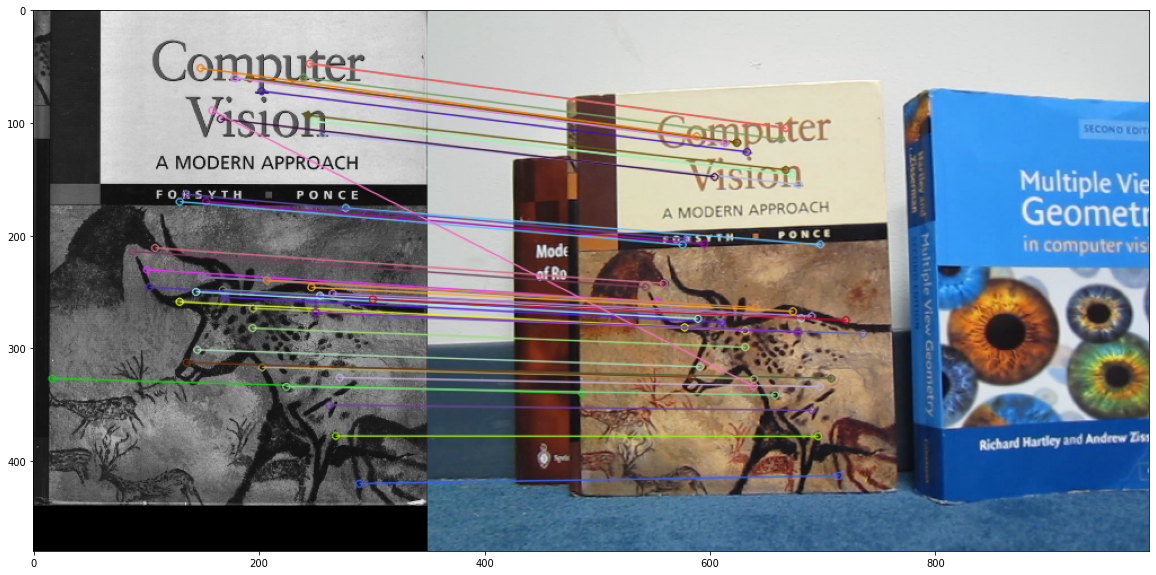

In [ ]:
# draw first 50 matches
matched_img = cv2.drawMatchesKnn(cover, kp_cover, book_frames[4], kp_book, matches[:50], book_frames[4].copy(), flags=2)

plt.figure(figsize=(20, 20))
plt.imshow(matched_img[:,:,::-1])
plt.show()

In [ ]:
# Get the matched keypoints
pts_cover = get_matched_pt(kp_cover, matches)
pts_book = get_matched_pt(kp_book, matches, points_type=1)

# Find the homography matrix
homography_mat , _= cv2.findHomography(pts_cover, pts_book)
homography = get_homograph_mat(pts_book, pts_cover)

homography_mat, homography

(array([[ 1.04278249e+00,  2.50573393e-01,  7.76141422e+01],
        [-7.98507026e-03,  1.09942226e+00,  6.45144663e+01],
        [ 1.22138337e-04,  7.56756670e-04,  1.00000000e+00]]),
 array([[-7.70506159e-01, -3.77826815e-01,  2.68502377e+02],
        [-9.48939919e-01, -1.62877812e-01,  2.54469341e+02],
        [-3.10482317e-03, -1.04315286e-03,  1.00000000e+00]]))

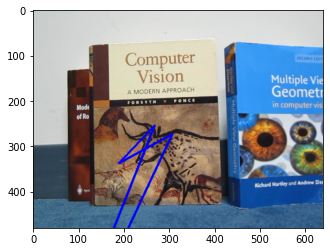

In [ ]:
# Get the corners of the cover in the book
corners = np.array([ 
        [0, 0],
        [0, cover_h-1],
        [cover_w-1, cover_h-1],
        [cover_w-1, 0]
    ],
    dtype=np.float32)
corners_book = transform_with_homography(homography, corners)

# Draw the cover in the book
outline = cv2.polylines(book_frames[4].copy(), [np.int32(corners_book)], True, (255, 0, 0), 3) 

plt.imshow(outline[:,:,::-1])

## Prepare trailer frame

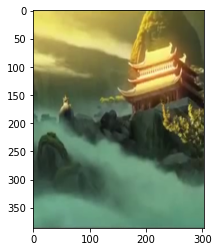

In [ ]:
# trailer dimensions wrt cover
# Calculate dimensions
x_min = int(max(0,np.min(corners_book[:,0])))
x_max = int(min(np.max(corners_book[:,0]),book_h))
y_min = int(max(0,np.min(corners_book[:,1])))
y_max = int(min(np.max(corners_book[:,1]),book_w))

# Calculate the dimensions of the new image
new_w = min(trailer_w,int(x_max - x_min))
new_h = min(trailer_h,int(y_max - y_min))

book_cover_h = min(int(x_max - x_min),book_h)
book_cover_w = min(int(y_max - y_min),book_w)

# center point
center = np.array([trailer_h/2, trailer_w/2])

# trailer corners
x_start = max(0, int(center[0] - new_h/2))
x_end = min(trailer_h, int(center[0] + new_h/2))
y_start = max(0, int(center[1] - new_w/2))
y_end = min(trailer_w, int(center[1] + new_w/2))

cropped_trailer = trailer_frames[4][x_start:x_end, y_start:y_end]
cropped_trailer = cv2.resize(cropped_trailer, (book_cover_h, book_cover_w))
#cropped_trailer = wrap_prespective(cropped_trailer, homography, (book_w, book_h))
plt.imshow(cropped_trailer[:,:,::-1])

## Combining all the previous steps

In [ ]:
# Calculate homography from cover to one book frame

import numpy as np
import cv2


def cover_to_book_homography(kp_cover, des_cover, book_gray, ransac = False)->np.ndarray:
    # Calculate homography from cover to book
    # Input: cover - cover image
    #        book - book image
    # Output: H - homography from cover to book

    assert book_gray.ndim == 2, 'book_gray must be grayscale'

    # Calculate descriptors (feature vectors)
    kp_book, des_book = get_image_sift_feature(book_gray)

    # Match the features
    matches = get_matches(des_cover, des_book)
    # Get the matched keypoints
    pts_cover = get_matched_pt(kp_cover, matches)
    pts_book = get_matched_pt(kp_book, matches, points_type=1)

    # Find the homography matrix
    mat = compute_homography_ransac(pts_book,pts_cover,CONFIDENCE_THRESH=50) if ransac else get_homograph_mat(pts_book, pts_cover)
    return mat

def trailer_dimensions(trailer_shape,corners)->np.ndarray:
    # dimensions
    trailer_h, trailer_w = trailer_shape[:2]

    # Calculate dimensions
    x_min,x_max,y_min,y_max = corners

    # Calculate the dimensions of the new image
    new_w = min(trailer_w,int(y_max - y_min))
    new_h = min(trailer_h,int(x_max - x_min))

    # center point
    center = np.array([trailer_h/2, trailer_w/2])

    # trailer corners
    x_start = max(0, int(center[0] - new_h/2))
    x_end = min(trailer_h, int(center[0] + new_h/2))
    y_start = max(0, int(center[1] - new_w/2))
    y_end = min(trailer_w, int(center[1] + new_w/2))

    return np.array([x_start, x_end, y_start, y_end])

def prep_trailer_frame(trailer, corners, cover_shape)->np.ndarray:
    # trailer dimensions wrt cover

    x_start, x_end, y_start, y_end = trailer_dimensions(trailer.shape,corners)

    cropped_trailer = trailer[x_start:x_end, y_start:y_end]
    cropped_trailer = cv2.resize(trailer, cover_shape)
    # cropped_trailer = wrap_prespective(cropped_trailer,homography,(book_h,book_w))
    return cropped_trailer

def overlay(cropped_trailer,book,corners, homography)->np.ndarray:
    '''
    # Create a mask of cover image and create its inverse mask also
    mask_3d = np.dstack([mask, mask, mask])
    mask = wrap_prespective(mask_3d,homography,(book.shape[1],book.shape[0]))[:,:,0]
    mask_inv = cv2.bitwise_not(mask)
    # Black-out the area of cover in book image
    book_bg = cv2.bitwise_and(book, book, mask=mask_inv)

    # Put cover in book image and modify the book image
    dst = cv2.add(book_bg, cropped_trailer)
    '''
    x_min,x_max,y_min,y_max = corners

    dst = book
    dst[x_min:x_max,y_min:y_max] = cropped_trailer

    return dst

def out_frame(book, kp_cover, des_cover, trailer, cover_shape, mask):
    book_shape = book.shape[:2]
    cover_h, cover_w = cover_shape[:2]
    book_gray = cv2.cvtColor(book, cv2.COLOR_BGR2GRAY)
    homography = cover_to_book_homography(kp_cover,des_cover, book_gray)

    # get the cover corners
    corners = np.array([ 
        [0, 0],
        [0, cover_h-1],
        [cover_w-1, cover_h-1],
        [cover_w-1, 0]
    ],
    dtype=np.float32)
    corners = transform_with_homography(homography, corners)

    # Calculate dimensions
    x_min = int(np.min(corners[:,0]))
    x_max = int(np.max(corners[:,0]))
    y_min = int(np.min(corners[:,1]))
    y_max = int(np.max(corners[:,1]))

    corners = (x_min,x_max,y_min,y_max)

    book_cover_w = int(y_max - y_min)
    book_cover_h = int(x_max - x_min)

    cover_shape = (book_cover_h,book_cover_w)

    # Get the trailer corners

    # Get the trailer frame
    cropped_trailer = prep_trailer_frame(trailer, corners, cover_shape)

    # Overlay the trailer frame on the book
    dst = overlay(cropped_trailer, book, corners, None)
    return dst


In [ ]:
def outframe(book,cover_kp,cover_des,trailer,cover_shape, ransac = False, thresh = .65, ratio = .75):
  # dimensions
  book_h, book_w = book.shape[:2]
  trailer_h, trailer_w = trailer.shape[:2]

  book_gray = cv2.cvtColor(book, cv2.COLOR_BGR2GRAY)

  # Calculate descriptors (feature vectors)
  kp_book, des_book = get_image_sift_feature(book_gray)

  # Match the features
  matches = get_matches(cover_des, des_book, ratio = ratio)    

  # Get the matched keypoints
  pts_cover = get_matched_pt(cover_kp, matches)
  pts_book = get_matched_pt(kp_book, matches, points_type=1)

  # Find the homography matrix
  homography = compute_homography_ransac(pts_book,pts_cover,thresh) if ransac else get_homograph_mat(pts_book, pts_cover)

  # Get the corners of the cover in the book
  corners = np.array([ 
          [0, 0],
          [0, cover_h-1],
          [cover_w-1, cover_h-1],
          [cover_w-1, 0]
      ],
      dtype=np.float32)
  corners_book = transform_with_homography(homography, corners)

  # Calculate dimensions
  x_min = int(max(np.min(corners_book[:,0]),0))
  x_max = int(min(np.max(corners_book[:,0]),book_h))
  y_min = int(max(np.min(corners_book[:,1]),0))
  y_max = int(min(np.max(corners_book[:,1]),book_w))

  new_shape = book[y_min:y_max,x_min:x_max].shape

  # Calculate the dimensions of the new image
  new_h = min(trailer_h,new_shape[0])
  new_w = min(trailer_w,new_shape[1])

  book_cover_h = new_shape[0]
  book_cover_w = new_shape[1]

  # center point
  center = np.array([trailer_h/2, trailer_w/2])

  # trailer corners
  x_start = max(0, int(center[0] - new_h/2))
  x_end = min(trailer_h, int(center[0] + new_h/2))
  y_start = max(0, int(center[1] - new_w/2))
  y_end = min(trailer_w, int(center[1] + new_w/2))

  cropped_trailer = trailer[x_start:x_end, y_start:y_end]
  cropped_trailer = cv2.resize(cropped_trailer, (book_cover_w, book_cover_h))

  dst = book.copy()
  try:
    dst[y_min:y_max,x_min:x_max] = cropped_trailer[:book_cover_h,:book_cover_w]
  except:
    dst = dst
  return dst

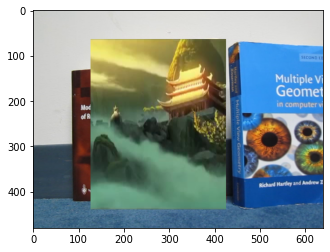

In [ ]:
cover_kp, cover_des = get_image_sift_feature(cover)
plt.imshow(outframe(book_frames[-20],cover_kp,cover_des,trailer_frames[1],cover.shape[:2],True)[:,:,::-1])

In [ ]:
def generate_video(out_name):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(out_name, fourcc, 20.0, (book_frames[0].shape[1], book_frames[0].shape[0]))
    #_, mask = cv2.threshold(cover, 1, 255, cv2.THRESH_BINARY)

    cover_kp, cover_des = get_image_sift_feature(cover)
    cover_shape = cover.shape[:2]

    for i in range(min(len(book_frames),len(trailer_frames))):
        book = book_frames[i]
        trailer = trailer_frames[i]
        out_current = outframe(book, cover_kp,cover_des,trailer,cover.shape[:2],True, ratio = .8)
        out.write(out_current)

    out.release()
    cv2.destroyAllWindows()

generate_video(OUT + '/out_ransac_8.mp4')

In [ ]:
# generate_video(OUT + '/out3.mp4')